In [ ]:
import glob
import os
import pickle
from scipy.stats import bernoulli

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc
from xgboost import XGBRegressor

import xgboost as xgb
import scipy.stats as st

from google.colab import drive
# mount google drive information in a google colaboratory directory
drive.mount('/content/gdrive')

path = r'gdrive/My Drive/Trabajos DS/Data/' # path

Mounted at /content/gdrive


### **5.Prediction Model**

**Final Data Load**

In [ ]:
# Load dataframe from pickled pandas object
file_name = path+'dataset_olist.pkl'
df= pd.read_pickle(file_name)
print('Shape of Dataset: ', df.shape[0], 'rows and', df.shape[1], 'columns')
df.head(3)


Shape of Dataset:  96470 rows and 22 columns


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,total_price,total_freight_value,distinct_product_order,total_weight,total_volume,isfragile,all_same_city,all_same_state,max_distance,customer_city_reduced,customer_state_reduced,percentage_freight_price,diff_customer_estimated_num,delayed,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,2017-10-10,2017-10-18,3149,sao paulo,SP,29.99,8.72,1,500.0,1976.0,1,0,1,18.566632,sao paulo,SP,0.225265,-8,0,10
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24,2018-08-07,2018-08-13,47813,barreiras,BA,118.70,22.76,1,400.0,4693.0,1,0,0,847.437333,Other,BA,0.160894,-6,0,7
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08,2018-08-17,2018-09-04,75265,vianopolis,GO,159.90,19.22,1,420.0,9576.0,0,0,0,512.100044,Other,GO,0.107302,-18,0,8


**Some useful functions**

In [ ]:
def get_dummies_fun(df,variable='SexoCalculado',reference_category='I'):
    '''get dummies with a reference category.
    '''

    df[variable] = pd.Categorical(df[variable])
    cat_vars=df[variable].cat.categories
    to_keep=[i for i in cat_vars if i not in reference_category]
    for var in to_keep:
        cat_list=variable+'_'+var
        df[cat_list]=np.where(df[variable]==var, 1, 0)
    df.drop(variable,axis=1,  inplace=True)
    return(df)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

**Preparation of Data**

First, as it has been seen in the exploratory analysis, the variable *IsFragile* appears not to be so relevant. Besides, regarding the total price variable (the one that indicates the sum price of the items of which an order consists on) is something on what there is no possible action. For this reason, the Models are being performed without these 2 variables to see if they return better metrics.

Also, the feature *purchase_months*, *customer_state_reduced* and *customer_city_reduced* are treated as dummies. As those variables represents something categoric, a good approach is to treat them as dummies.

In [ ]:
df['purchase_month'] = pd.Categorical(df['purchase_month']).astype('str')

df = get_dummies_fun(df,variable='customer_state_reduced',reference_category='Other')
print(df.shape)
df = get_dummies_fun(df,variable='customer_city_reduced',reference_category='Other')
print(df.shape)
df = get_dummies_fun(df,variable='purchase_month',reference_category='1')
print(df.shape)

df = df.drop(['order_id','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date',\
              'customer_zip_code_prefix','customer_city','customer_state','diff_customer_estimated_num','total_price',\
             'isfragile'], axis=1)
print('Shape of Dataset: ', df.shape[0], 'rows and', df.shape[1], 'columns')

(96470, 35)
(96470, 44)
(96470, 54)
Shape of Dataset:  96470 rows and 44 columns


**Models**

The problem involves a binary response variable (0: not delayed; 1: delayed) so classification techniques need to be used to get the suitable model.

**Logistic Regression, Random Forest and XGBoost** will be used to predict if an order is going to be delayed or not.

The main metrics which will be considered are **Balance Accuracy** and **Recall**.

***Balance Accuracy***: The balanced accuracy in binary problems deal with imbalanced datasets. It is based on two metrics: recall and specificity which is also known as true negative rate (TNR), or 1 – false positive rate: *(TN/(FP+TN)*.

 So, balance accuracy is the mean of those two: (recall + TNR)/2

***Recall***: Is the fraction of all positive instances that the classifier correclty indentifies as positive. *(TP/(TP+FN))*   

***Log Loss***: Is a classification metric based on probabilities. It indicates how close the prediction probability is to the corresponding actual/true value. The more the predicted probability diverges from the actual value, the higher is the log-loss value. A lower log-loss value means better predictions.

**The most imoprtant task in this problem is to make a correct prediction about delayed orders. 
The worst scenario, that should be avoid, is to promise to the customer an estimated date of order arrival that is then delayed.**

In [ ]:
# get the dependent and the independents variables
X=df[['total_freight_value', 'distinct_product_order', 'total_weight',
       'total_volume', 'all_same_city', 'all_same_state', 'max_distance',
       'percentage_freight_price','customer_state_reduced_BA',
       'customer_state_reduced_CE', 'customer_state_reduced_DF',
       'customer_state_reduced_ES', 'customer_state_reduced_GO',
       'customer_state_reduced_MG', 'customer_state_reduced_MT',
       'customer_state_reduced_PA', 'customer_state_reduced_PE',
       'customer_state_reduced_PR', 'customer_state_reduced_RJ',
       'customer_state_reduced_RS', 'customer_state_reduced_SC',
       'customer_state_reduced_SP', 'customer_city_reduced_belo horizonte',
       'customer_city_reduced_brasilia', 'customer_city_reduced_campinas',
       'customer_city_reduced_curitiba', 'customer_city_reduced_guarulhos',
       'customer_city_reduced_porto alegre',
       'customer_city_reduced_rio de janeiro',
       'customer_city_reduced_salvador',
       'customer_city_reduced_sao bernardo do campo',
       'customer_city_reduced_sao paulo', 'purchase_month_10',
       'purchase_month_11', 'purchase_month_12', 'purchase_month_2',
       'purchase_month_3', 'purchase_month_4', 'purchase_month_5',
       'purchase_month_6', 'purchase_month_7', 'purchase_month_8',
       'purchase_month_9']]
y = df['delayed']

In [ ]:
# get train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0,test_size =0.2)

It is necesary to standarize the variables. In this case a *normal standardization* will be used (subtract mean and divide on the deviation).

In [ ]:
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

**Baseline**   
A fundamental aspect to consider before running the models is to compare them with a baseline. 
In this case, a basic **Dummy Classifier** is going to be used.

(*DummyClassifier* is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with imbalanced classes.)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(Xtrain, ytrain)
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_dummy_predictions = dummy_majority.predict(Xtest)

print(y_dummy_predictions)
print('Mean accuracy on the given test data and labels', dummy_majority.score(Xtest, ytest))
confusion = confusion_matrix(ytest, y_dummy_predictions)
print('Most frequent class (dummy classifier)\n', confusion)

[0 0 0 ... 0 0 0]
Mean accuracy on the given test data and labels 0.9314294599357313
Most frequent class (dummy classifier)
 [[17971     0]
 [ 1323     0]]


Accuracy  :  0.931
Recall  :  0.0
Log Loss:  2.368
balanced accuracy:  0.5


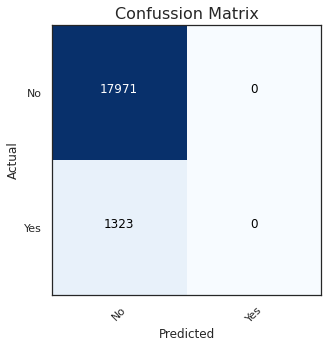

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, y_dummy_predictions)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)

print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,y_dummy_predictions),3))
print("balanced accuracy: ",round((rec + tnr)/2,3))

***Logistic Regression***

In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [ ]:
penalty = [l1, l2]
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] #To find the best paramenter value
class_weight = [{1:0.97, 0:0.03}, {1:0.92, 0:0.08}, {1:0.95, 0:0.05}, {1:0.96, 0:0.04}] #to find the best class weight
#solver = [liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight)
                  
##Grid-Search will build a model on each parameter combination possible.
##It iterates through every parameter combination and stores a model for each combination. 
grid_lr = GridSearchCV(estimator=LogisticRegression(solver='liblinear'),
                        param_grid=param_grid,
                        scoring='balanced_accuracy',
                        cv = 3, verbose=2, n_jobs = -1) 

#Fit the model
grid_lr = grid_lr.fit(Xtrain, ytrain)

#predict
ypred = grid_lr.predict(Xtest)

yproba = grid_lr.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 23.0min finished


Accuracy  :  0.682
Recall  :  0.651
Log Loss:  0.594
balanced accuracy:  0.668


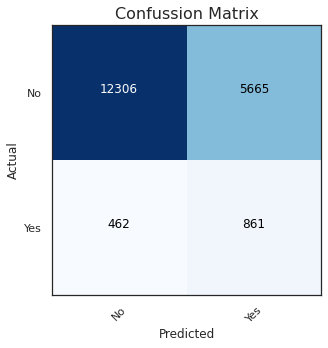

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)

print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))
print("balanced accuracy: ",round((rec + tnr)/2,3))

In [ ]:
lr_fit = grid_lr.best_estimator_
lr_fit

LogisticRegression(C=0.001, class_weight={0: 0.08, 1: 0.92}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

*Coefficients*

In [ ]:
# Combine feature names and coefficients into pandas DataFrame
feature_names = pd.DataFrame(X.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(lr_fit.coef_), columns = ['Coefficient'])
coefficients = pd.concat([feature_names, log_coef], axis = 1)

# Calculate exponent of the logistic regression coefficients
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])

# Remove coefficients that are equal to zero
coefficients = coefficients[coefficients['Coefficient']!=0]

# Print the values sorted by the exponent coefficient
print(coefficients.sort_values(by=['Exp_Coefficient']))

                                        Feature  Coefficient  Exp_Coefficient
39                             purchase_month_6    -0.196776         0.821374
40                             purchase_month_7    -0.115880         0.890582
21                    customer_state_reduced_SP    -0.114594         0.891728
13                    customer_state_reduced_MG    -0.098631         0.906077
1                        distinct_product_order    -0.076247         0.926587
17                    customer_state_reduced_PR    -0.072276         0.930274
32                            purchase_month_10    -0.063529         0.938447
19                    customer_state_reduced_RS    -0.057161         0.944442
42                             purchase_month_9    -0.041508         0.959341
5                                all_same_state    -0.041026         0.959804
37                             purchase_month_4    -0.039923         0.960864
14                    customer_state_reduced_MT    -0.027183    

As the Logit model is not linear, the marginal effect is not constant but will depend on the values ​​taken by the explicative variables. The estimated coefficients cannot be interpreted as marginal effects but only their sign can be looked at to understand the direction of the impact.

However, it is important to know if the coefficients are significant for their interpretation to be valid. The p-value associated with each coefficient indicates the significance. For this case it was not tested but what has to be calculated is the t statistic, dividing the coefficient on the standard error returned by the logit regression. (If this value is greater than 1.96 or lower than -1.96, it could be confirmed that the coefficient is significative on the 5%).

Looking at the **coefficients** estimated by logistic regression, some variables interpretations are:

* *purchase_month_3* --> It has a positive coeficient (0.232) which means that 
if the month is March, it increases the probability of an order delay, 
as long as the coefficient is significant.

This make sense regarding the previous analysis, when the number of total orders by month and the number of delay orders were compute, showing that March was a month of spikes of delayed orders.

* *customer_state_reduce_SP* --> It has a negative coeficient (-0.114) which menas that if the state is SP, the probability of a delayed order decreases (as long as the coefficient is significant). This is well seen in the exploratory analysis, were SP has low percentage of delay orders.

* *max_distance* -->  It has a positive coeficient (0.109). The probability of a delay in an order increases when there exists many kilometers of distance (as long as the coefficient is significant). This also confirms the positive influence in delay that de distance between sellers and customer has.

* *total_weight* --> Also has a positive coeficient. The probability of an order delay increases when the order is heavier, as long as the coefficient is significant.

***Random Forest***

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(3,12))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf=list(range(1,15))
# Method of selecting samples for training each tree
bootstrap = [True, False]

class_weight = [{1:0.97, 0:0.03}, {1:0.92, 0:0.08}, {1:0.95, 0:0.05}, {1:0.96, 0:0.04}]

# Create the random grid
hyperparameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

In [ ]:
# First create the base model to tune
rf = RandomForestClassifier()
##Random Search replaces the exhaustive enumeration of all combinations by selecting them randomly.

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_best_model = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = hyperparameters,
                                   scoring='balanced_accuracy', 
                                   n_iter = 50, cv = 3, verbose=4, 
                                   random_state=42, n_jobs = -1)

# Fit the random search model
rf_best_model.fit(Xtrain, ytrain)

ypred = rf_best_model.predict(Xtest)
yproba = rf_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 12.0min finished


In [ ]:
rf_best_model.best_params_

{'bootstrap': False,
 'class_weight': {0: 0.04, 1: 0.96},
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 12,
 'min_samples_split': 5,
 'n_estimators': 66}

In [ ]:
rf_fit = rf_best_model.best_estimator_

Accuracy  :  0.751
Recall  :  0.633
Log Loss:  0.535
balanced accuracy:  0.696


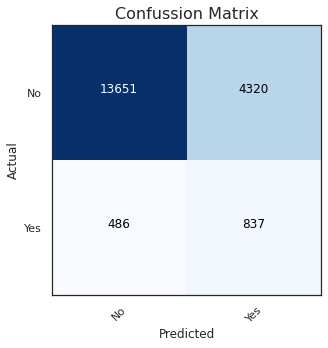

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)

print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))
print("balanced accuracy: ",round((rec + tnr)/2,3))

*Random Forest - Feature Importance*

Feature ranking:
1. feature 6 (0.155505) -> max_distance
2. feature 0 (0.123490) -> total_freight_value
3. feature 7 (0.114569) -> percentage_freight_price
4. feature 2 (0.104495) -> total_weight
5. feature 3 (0.102342) -> total_volume
6. feature 36 (0.049068) -> purchase_month_3
7. feature 39 (0.047669) -> purchase_month_6
8. feature 41 (0.027491) -> purchase_month_8
9. feature 21 (0.026730) -> customer_state_reduced_SP
10. feature 40 (0.024934) -> purchase_month_7
11. feature 35 (0.024519) -> purchase_month_2
12. feature 33 (0.023484) -> purchase_month_11
13. feature 18 (0.020862) -> customer_state_reduced_RJ
14. feature 5 (0.017848) -> all_same_state
15. feature 13 (0.013827) -> customer_state_reduced_MG
16. feature 38 (0.013518) -> purchase_month_5
17. feature 37 (0.011358) -> purchase_month_4
18. feature 34 (0.008134) -> purchase_month_12
19. feature 32 (0.007583) -> purchase_month_10
20. feature 42 (0.007070) -> purchase_month_9
21. feature 31 (0.006891) -> customer_city_reduced_

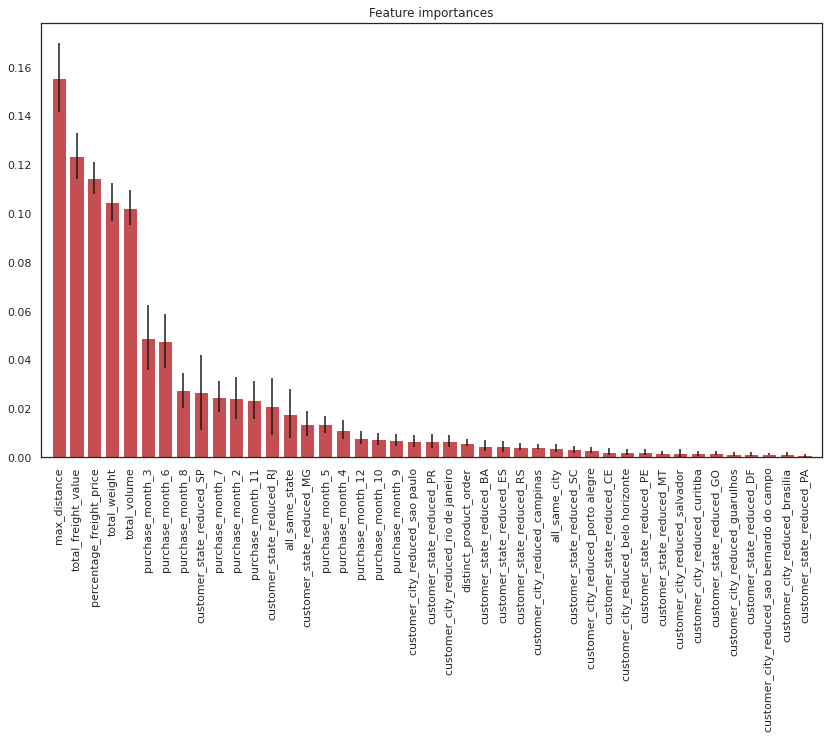

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

importances = rf_fit.feature_importances_ #rf
std = np.std([tree.feature_importances_ for tree in rf_fit.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

variables=['total_freight_value', 'distinct_product_order', 'total_weight',
       'total_volume', 'all_same_city', 'all_same_state', 'max_distance',
       'percentage_freight_price','customer_state_reduced_BA',
       'customer_state_reduced_CE', 'customer_state_reduced_DF',
       'customer_state_reduced_ES', 'customer_state_reduced_GO',
       'customer_state_reduced_MG', 'customer_state_reduced_MT',
       'customer_state_reduced_PA', 'customer_state_reduced_PE',
       'customer_state_reduced_PR', 'customer_state_reduced_RJ',
       'customer_state_reduced_RS', 'customer_state_reduced_SC',
       'customer_state_reduced_SP', 'customer_city_reduced_belo horizonte',
       'customer_city_reduced_brasilia', 'customer_city_reduced_campinas',
       'customer_city_reduced_curitiba', 'customer_city_reduced_guarulhos',
       'customer_city_reduced_porto alegre',
       'customer_city_reduced_rio de janeiro',
       'customer_city_reduced_salvador',
       'customer_city_reduced_sao bernardo do campo',
       'customer_city_reduced_sao paulo', 'purchase_month_10',
       'purchase_month_11', 'purchase_month_12', 'purchase_month_2',
       'purchase_month_3', 'purchase_month_4', 'purchase_month_5',
       'purchase_month_6', 'purchase_month_7', 'purchase_month_8',
       'purchase_month_9']
variables_ordenadas=[]

for i in range(0,len(indices)): #TENES IDEA PORQUE NO ME TOMA  range(0,len(indices) ?
    variables_ordenadas.append(variables[indices[i]])
# Print the feature ranking
print("Feature ranking:")

for f in range(0,len(indices)):
    #print("feature {} {} --> {}").format(indices[f], importances[indices[f]], variables_ordenadas[f])
    print("%d. feature %d (%f) -> %s" % (f + 1, indices[f], importances[indices[f]],variables_ordenadas[f]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(14,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), variables_ordenadas)
plt.xlim([-1, X.shape[1]])

x = plt.gca().xaxis
#One specific to text is the set rotation function which changes the rotation based on degrees.
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(90)
    
plt.show()

Observing **feature importance** of Random Forest it can be seen that the variables maximum distance between sellers and customers, total freight value, total weight, total volume are the ones that have more influence on the delay of orders. This is consistent with what has been found in the exploratory analysis regarding the influence of distance, freight value and size of the order.

Besides, the month 3 (March) is showed as an important variable. This could also be infered in the exploratory analysis as it is one of the months where there was a peak in number of delayed orders.

On the other hand, the cities don't appear to be so much relevant to predict if an order is going to be delayed or not. 

***XgBoost***

In [ ]:
model_xgb = xgb.XGBClassifier(n_jobs=-1)

one_to_left = st.beta(10, 1) #  This distribution will return values between 0 and 1, nearer to 1

max_depth = list(range(3,12))
max_depth.append(None)

hyperparameters = {  
    "n_estimators": st.randint(50,200), # Number of boosted trees to fit.
    "max_depth": max_depth,     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
    'class_weight':[{1:0.97, 0:0.03}, {1:0.92, 0:0.08}, {1:0.95, 0:0.05}, {1:0.96, 0:0.04}]
}

xgb_best_model = RandomizedSearchCV(estimator = model_xgb, 
                            param_distributions = hyperparameters,
                            scoring='balanced_accuracy',
                            n_iter = 50, cv = 3, verbose=4, 
                            random_state=42, n_jobs = -1)
xgb_best_model.fit(Xtrain, ytrain)

ypred = xgb_best_model.predict(Xtest)
yproba = xgb_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 31.5min finished


In [ ]:
xgb_best_model.best_params_

{'class_weight': {0: 0.08, 1: 0.92},
 'colsample_bytree': 0.7987640929363142,
 'gamma': 2.3611653311740435,
 'learning_rate': 0.35398216357503426,
 'max_depth': 10,
 'min_child_weight': 15.410321227829296,
 'n_estimators': 63,
 'reg_alpha': 1.527390919062267,
 'subsample': 0.8937765500616195}

Accuracy  :  0.931
Recall  :  0.034
Log Loss:  0.22
balanced accuracy:  0.516


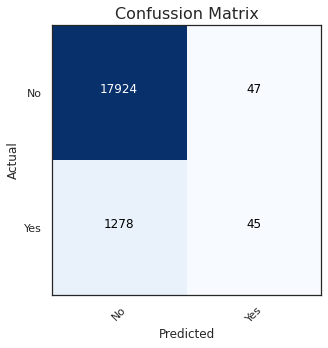

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

# Measures : 
tn, fp, fn, tp = cnf_matrix.ravel()

# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)

print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))
print("balanced accuracy: ",round((rec + tnr)/2,3))


This model did not return metrics as good as the previous two models. It has predicted much more non-delays than delays.

As could be observed in the previous models, the variables referring to cities do not appear to be relevant. For this reason, a **second Random Forest** model will be made without those variables. Besides, variables regarding to DF, GO and PA sates will be also remove.

In [ ]:
# get the dependent and the independents variables
X=df[['total_freight_value', 'distinct_product_order', 'total_weight',
       'total_volume', 'all_same_state', 'max_distance',
       'percentage_freight_price','customer_state_reduced_BA',
       'customer_state_reduced_CE', 'customer_state_reduced_ES', 
       'customer_state_reduced_MG', 'customer_state_reduced_MT',
       'customer_state_reduced_PE',
       'customer_state_reduced_PR', 'customer_state_reduced_RJ',
       'customer_state_reduced_RS', 'customer_state_reduced_SC',
       'customer_state_reduced_SP', 'purchase_month_10',
       'purchase_month_11', 'purchase_month_12', 'purchase_month_2',
       'purchase_month_3', 'purchase_month_4', 'purchase_month_5',
       'purchase_month_6', 'purchase_month_7', 'purchase_month_8',
       'purchase_month_9']]
y = df['delayed']

# get train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0,test_size =0.2)

#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(3,12))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf=list(range(1,15))
# Method of selecting samples for training each tree
bootstrap = [True, False]

class_weight = [{1:0.97, 0:0.03}, {1:0.92, 0:0.08}, {1:0.95, 0:0.05}, {1:0.96, 0:0.04}]

# Create the random grid
hyperparameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_best_model = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = hyperparameters,
                                   scoring='balanced_accuracy', 
                                   n_iter = 50, cv = 3, verbose=4, 
                                   random_state=42, n_jobs = -1)

# Fit the random search model
rf_best_model.fit(Xtrain, ytrain)

ypred = rf_best_model.predict(Xtest)
yproba = rf_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 14.9min finished


In [ ]:
rf_best_model.best_params_

{'bootstrap': True,
 'class_weight': {0: 0.05, 1: 0.95},
 'max_depth': 11,
 'max_features': 'auto',
 'min_samples_leaf': 13,
 'min_samples_split': 5,
 'n_estimators': 166}

In [ ]:
rf_fit = rf_best_model.best_estimator_

Accuracy  :  0.644
Recall  :  0.741
Log Loss:  0.659
balanced accuracy:  0.689


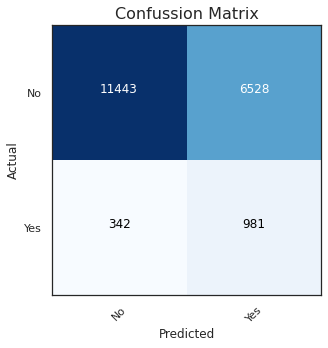

In [ ]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)

print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))
print("balanced accuracy: ",round((rec + tnr)/2,3))

Feature ranking:
1. feature 5 (0.127609) -> max_distance
2. feature 23 (0.108203) -> purchase_month_3
3. feature 26 (0.092134) -> purchase_month_6
4. feature 0 (0.084010) -> total_freight_value
5. feature 6 (0.065443) -> percentage_freight_price
6. feature 2 (0.061215) -> total_weight
7. feature 3 (0.056883) -> total_volume
8. feature 18 (0.052022) -> customer_state_reduced_SP
9. feature 22 (0.043158) -> purchase_month_2
10. feature 28 (0.042888) -> purchase_month_8
11. feature 15 (0.042368) -> customer_state_reduced_RJ
12. feature 20 (0.041422) -> purchase_month_11
13. feature 27 (0.038053) -> purchase_month_7
14. feature 4 (0.034373) -> all_same_state
15. feature 10 (0.022708) -> customer_state_reduced_MG
16. feature 24 (0.011562) -> purchase_month_4
17. feature 25 (0.010306) -> purchase_month_5
18. feature 14 (0.009611) -> customer_state_reduced_PR
19. feature 7 (0.009216) -> customer_state_reduced_BA
20. feature 21 (0.007393) -> purchase_month_12
21. feature 19 (0.007390) -> purcha

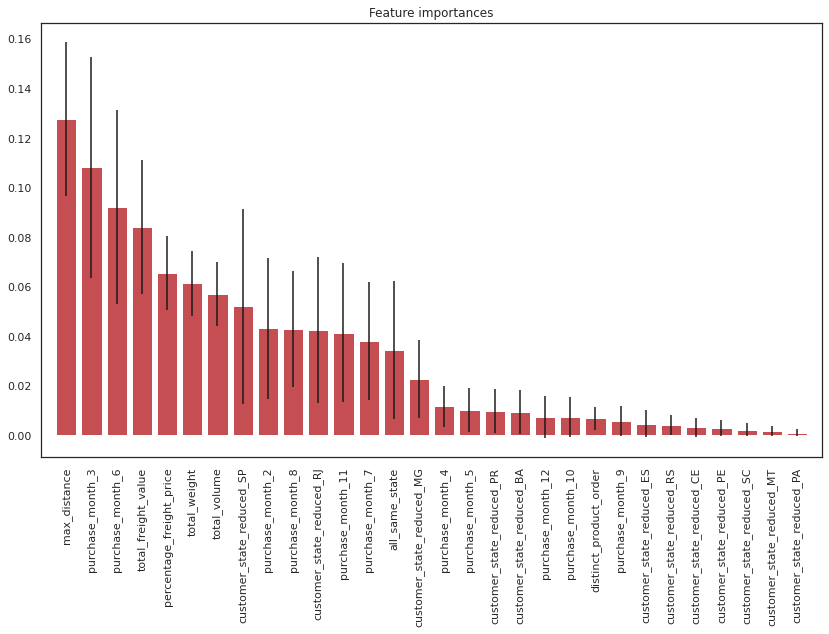

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

importances = rf_fit.feature_importances_ #rf
std = np.std([tree.feature_importances_ for tree in rf_fit.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

variables=['total_freight_value', 'distinct_product_order', 'total_weight',
       'total_volume', 'all_same_state', 'max_distance',
       'percentage_freight_price','customer_state_reduced_BA',
       'customer_state_reduced_CE', 'customer_state_reduced_ES', 
       'customer_state_reduced_MG', 'customer_state_reduced_MT',
       'customer_state_reduced_PA', 'customer_state_reduced_PE',
       'customer_state_reduced_PR', 'customer_state_reduced_RJ',
       'customer_state_reduced_RS', 'customer_state_reduced_SC',
       'customer_state_reduced_SP', 'purchase_month_10',
       'purchase_month_11', 'purchase_month_12', 'purchase_month_2',
       'purchase_month_3', 'purchase_month_4', 'purchase_month_5',
       'purchase_month_6', 'purchase_month_7', 'purchase_month_8',
       'purchase_month_9']
variables_ordenadas=[]

for i in range(0,len(indices)): #TENES IDEA PORQUE NO ME TOMA  range(0,len(indices) ?
    variables_ordenadas.append(variables[indices[i]])
# Print the feature ranking
print("Feature ranking:")

for f in range(0,len(indices)):
    #print("feature {} {} --> {}").format(indices[f], importances[indices[f]], variables_ordenadas[f])
    print("%d. feature %d (%f) -> %s" % (f + 1, indices[f], importances[indices[f]],variables_ordenadas[f]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(14,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), variables_ordenadas)
plt.xlim([-1, X.shape[1]])

x = plt.gca().xaxis
#One specific to text is the set rotation function which changes the rotation based on degrees.
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(90)
    
plt.show()

As in the first random forest model, the distance between consumers and sellers is the variable that best makes the model perform, followed by the variable for the month of March

In [ ]:
#Save models
with open(os.path.join(r'gdrive/My Drive/Trabajos DS/Models', 'lg_classification.pkl'), 'wb') as f:
    pickle.dump(grid_lr, f)
with open(os.path.join(r'gdrive/My Drive/Trabajos DS/Models', 'rf_classification.pkl'), 'wb') as f:
    pickle.dump(rf_best_model, f)
with open(os.path.join(r'gdrive/My Drive/Trabajos DS/Models', 'xgboost_classification.pkl'), 'wb') as f:
    pickle.dump(xgb_best_model, f)

**Final Selection and conclusions**

In [ ]:
Comparison between metric of each of the final models:

Comparison between metric of each of the final models:

| **Metric** | **Logistic** | **Random Forest** | **XgBoost** | **Baseline** |
|--|--|--|--|--|
| **Accuracy** | 0.682 | 0.644 | **0.931** | 0.931 |
| **Recall** | 0.651 | **0.741** | 0.034  |	0.0 |
| **Log Loss**| 0.594 | 0.659 |	**0.22** |  |
| **balanced accuracy**| 0.668 | **0.689** | 0.516 | 0.5 |

Comparing the results from different techniques, **Random Forest** gives the best results.


The most important task regarding this problem is to make a correct prediction about delayed orders. The worst scenario is to promise to the customer an estimated date that will be not true.
For this reason, recall metric makes sense. The more correctly the machine learning model predicts delayed orders, the more it will avoid consumer displeasure. This would then be reflected in reviews score and in a re-purchase though Olist e-commerce done by the customer

**Main findings**

* The fact that an order is fragile or not does not influence the delayed of an order
* Cities of sellers and customers do not influence the order delay as the states do
* Distance between sellers and customers is relevant for predicting delay. The more distance, the more delay.
* Order delays occurs, in general, when the order is composed of few distinct products, and not when the order consists on more than 2 products.
* March is a month where delays occur the most.
* June is a month where very few order delay cases occurs.
* The SP state has low percentage of delay orders. This state might have attributes which make the area a very efficient one in terms of orders delivery.
* The size of the order (weight and volume) influences the order delay in a positive way. The heavier the order is, the more probability of delay.
* If a customer and a seller live in the same state, the probability of delay of the order decreases.
* Freight value also is relevant for order delay fact. The lower the value of the freight, the more probability of delay.

**Possible actions to improve ML models performance**:
* Look for outliers, make a deep analysis and remove them
* Caluculate significance of coefficients to make a more accurate analysis on which variables really affects delay and which ones do not.
* Make a map view of cities and states and their order delay level (this would be useful for a more efficent view of the areas problem)



**Possible management actions:**

* Facilitate the consumer to find their products through the closest seller to his or her area. This could be done maybe trough an algoritm which takes the adress of the customer and offers him or her the closet seller.

* Offer the customer *related products* in reference on what he or she has choosen in the e-commerce website. If the consumer buys more than one product, the chances of delay might decrease.

* Offer discounts or make marketing decisions to motivate the consumer to buy in June, and not in March, August or November.

* Study the SP state to see which attributes could make it have low order delay cases and, therefore, understand which state factors could be relevant to reduce delay.

* Review freight and transportation attributes. Try to avoid the fact that lower value of freight means more chance of delay, for instance.